In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import plot_importance

In [2]:
#Read dataset
df = pd.read_csv('./data/IoT Network Intrusion Dataset.csv')

In [3]:
cols = (df.dtypes=='object')
object_cols = list(cols[cols].index)
object_cols

['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp', 'Label', 'Cat', 'Sub_Cat']

In [4]:
x=[0,1,3,85]
df.drop(df.columns[x], axis = 1, inplace=True)
df.drop('Timestamp', axis=1, inplace = True)

In [5]:
df

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat
0,10000,10101,17,75,1,1,982.0,1430.0,982.0,982.0,...,0.0,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai
1,2179,554,6,5310,1,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS
2,52727,9020,6,141,0,3,0.0,2806.0,0.0,0.0,...,0.0,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan
3,52964,9020,6,151,0,2,0.0,2776.0,0.0,0.0,...,0.0,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai
4,36763,1900,17,153,2,1,886.0,420.0,452.0,434.0,...,0.0,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,56112,8043,17,277,1,1,18.0,18.0,18.0,18.0,...,0.0,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,Anomaly,Mirai
625779,4570,554,6,1658,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,Anomaly,DoS
625780,52739,9020,6,77,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Anomaly,Scan
625781,9020,49784,6,240,2,1,2776.0,1388.0,1388.0,1388.0,...,0.0,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,Normal,Normal


In [6]:
df.Cat.value_counts()

Mirai                415677
Scan                  75265
DoS                   59391
Normal                40073
MITM ARP Spoofing     35377
Name: Cat, dtype: int64

In [7]:
df.dtypes

Src_Port           int64
Dst_Port           int64
Protocol           int64
Flow_Duration      int64
Tot_Fwd_Pkts       int64
                  ...   
Idle_Std         float64
Idle_Max         float64
Idle_Min         float64
Label             object
Cat               object
Length: 81, dtype: object

In [8]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [9]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
df.iloc[:, -2] = labelencoder.fit_transform(df.iloc[:, -2])


In [10]:
df.Cat.value_counts()

2    415677
4     75265
0     59391
3     40073
1     35377
Name: Cat, dtype: int64

In [11]:
# df_minor = df[(df['Cat']==1)|(df['Cat']==3)]
# df_major = df.drop(df_minor.index)

In [12]:
# df_major.Cat.value_counts()

In [13]:
# X = df_major.drop(['Cat'],axis=1) 
# y = df_major.iloc[:, -1].values.reshape(-1,1)
# y=np.ravel(y)


In [14]:
X = df.drop(['Cat'],axis=1) 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [15]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [16]:
klabel=kmeans.labels_
df['klabel']=klabel

In [17]:
df['klabel'].value_counts()

628    4303
943    4268
709    4221
516    3932
196    3834
       ... 
442       9
786       9
247       7
683       4
214       3
Name: klabel, Length: 990, dtype: int64

In [18]:
cols = list(df)
cols.insert(81, cols.pop(cols.index('Cat')))
df = df.loc[:, cols]

In [19]:
def typicalSampling(group):
    name = group.name
    frac = 0.04 #0.008
    return group.sample(frac=frac)

result = df.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [20]:
result['Cat'].value_counts()

2    16603
4     3032
0     2381
3     1603
1     1411
Name: Cat, dtype: int64

In [21]:
result

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,klabel,Cat
457107,0.166896,-0.908473,-0.738205,-0.140251,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.169196,-0.045443,-0.145313,-0.166811,0,0,2
387596,0.156621,-0.908473,-0.738205,-0.147973,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.181974,-0.045443,-0.154733,-0.180787,0,0,2
487179,0.163903,-0.908473,-0.738205,-0.158268,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.199012,-0.045443,-0.167291,-0.199422,0,0,2
474437,0.157026,-0.908473,-0.738205,-0.136534,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.163043,-0.045443,-0.140778,-0.160082,0,0,2
387834,0.163983,-0.908473,-0.738205,-0.132244,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.155944,-0.045443,-0.135545,-0.152318,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108980,-1.051984,2.069300,-0.738205,-0.157696,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.198065,-0.045443,-0.166594,-0.198386,0,999,4
217195,-1.051984,2.070041,-0.738205,-0.157124,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.197119,-0.045443,-0.165896,-0.197351,0,999,4
537184,-1.051984,2.071295,-0.738205,-0.158840,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.199959,-0.045443,-0.167989,-0.200457,0,999,4
189883,-1.051984,2.071295,-0.738205,-0.158554,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.199485,-0.045443,-0.167640,-0.199939,0,999,4


In [22]:
result = result.drop(['klabel'],axis=1)
#result = result.append(df_minor)

In [23]:
result.to_csv('./data/IoTID20_sample_km.csv',index=0)

In [24]:
df=pd.read_csv('./data/IoTID20_sample_km.csv')

In [25]:
X = df.drop(['Cat'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [27]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [28]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [29]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [30]:
X_fs = df[fs].values

In [31]:
X_fs.shape

(25030, 39)

In [32]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [33]:
X_fss = fcbf.fit_transform(X_fs,y)

In [34]:
X_fss.shape

(25030, 20)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [36]:
X_train.shape

(20024, 20)

In [37]:
pd.Series(y_train).value_counts()

2    13282
4     2426
0     1905
3     1282
1     1129
dtype: int64

# XGBoost

Accuracy of XGBoost: 0.9748302037554935
Precision of XGBoost: 0.9748179968787276
Recall of XGBoost: 0.9748302037554935
F1-score of XGBoost: 0.9742337622865396
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.93      0.79      0.86       282
           2       0.97      1.00      0.98      3321
           3       1.00      0.97      0.98       321
           4       0.99      0.93      0.96       606

    accuracy                           0.97      5006
   macro avg       0.98      0.94      0.96      5006
weighted avg       0.97      0.97      0.97      5006



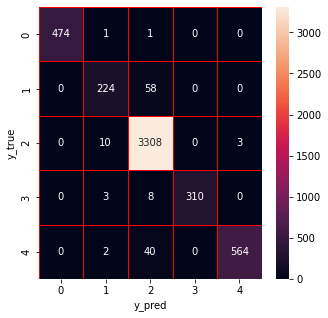

In [38]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### BO-TPE

In [74]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:44<00:00,  2.21s/trial, best loss: -0.9874151018777467]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.8919517746167342, 'max_depth': 84.0, 'n_estimators': 70.0}


Accuracy of XGBoost: 0.9862165401518178
Precision of XGBoost: 0.9861529145058426
Recall of XGBoost: 0.9862165401518178
F1-score of XGBoost: 0.9861469379284884
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.93      0.90      0.91       282
           2       0.99      0.99      0.99      3321
           3       1.00      0.98      0.99       321
           4       0.99      0.98      0.99       606

    accuracy                           0.99      5006
   macro avg       0.98      0.97      0.97      5006
weighted avg       0.99      0.99      0.99      5006



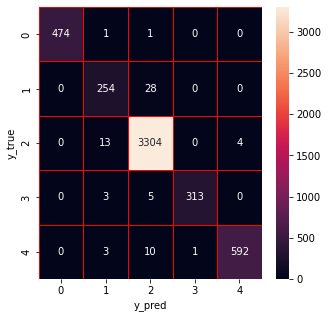

In [39]:
xg = xgb.XGBClassifier(learning_rate= 0.8919517746167342, n_estimators = 70, max_depth = 84)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [40]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

# Random Forest 

Accuracy of RF: 0.9794246903715541
Precision of RF: 0.9792639107542914
Recall of RF: 0.9794246903715541
F1-score of RF: 0.9792330945522596
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.90      0.85      0.87       282
           2       0.98      0.99      0.99      3321
           3       0.99      0.97      0.98       321
           4       0.99      0.96      0.98       606

    accuracy                           0.98      5006
   macro avg       0.97      0.95      0.96      5006
weighted avg       0.98      0.98      0.98      5006



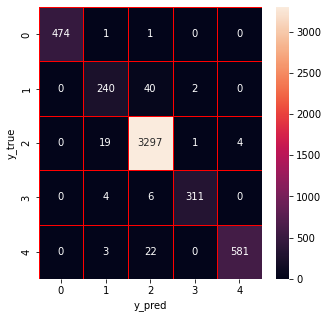

In [41]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### GA


In [44]:


#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
        'n_estimators': range(20,200),
    "max_features":range(1,20),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
             }
# Set the hyperparameters of GA                 
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)



C:\python310\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.9387534956095225	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=28, RandomForestClassifier__max_features=17, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=26)

Generation 2 - Current Pareto front scores:

-1	0.9387534956095225	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=28, RandomForestClassifier__max_features=17, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=26)

Generation 3 - Current Pareto front scores:

-1	0.9387534956095225	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=28, RandomForestClassifier__max_features=17, RandomForestClassifier__min_samples_leaf=3, RandomForestCla

TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['gini',
                                                                                      'entropy'],
                                                                        'max_depth': range(10, 100),
                                                                        'max_features': range(1, 20),
                                                                        'min_samples_leaf': range(1, 11),
                                                                        'min_samples_split': range(2, 11),
                                                                        'n_estimators': range(20, 200)}},
               cv=3, early_stop=5, generations=3, offspring_size=5,
               population_size=10, scoring='accuracy', verbosity=3)

### PSO  RF

In [49]:
#Random Forest
import optunity
import optunity.metrics


# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
         }
# Define the objective function
@optunity.cross_validated(x=X, y=y, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri='gini'
    else:
        cri='entropy'
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'n_estimators': 69.53969430711243, 'max_features': 18.693497877713614, 'max_depth': 39.88040559643254, 'min_samples_split': 5.36533203125, 'min_samples_leaf': 3.9892578125, 'criterion': 0.85927734375}
Accuracy:0.942828867251604
Random Forest: Hyperopt estimated optimum {'n_estimators': 69.53969430711243, 'max_features': 18.693497877713614, 'max_depth': 39.88040559643254, 'min_samples_split': 5.36533203125, 'min_samples_leaf': 3.9892578125, 'criterion': 0.85927734375}


### BO-TPE

In [78]:

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [01:13<00:00,  3.66s/trial, best loss: -0.9844186975629244]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 43.0, 'max_features': 19.0, 'min_samples_leaf': 3.0, 'min_samples_split': 2.0, 'n_estimators': 190.0}


## After HPO

Accuracy of RF: 0.9830203755493407
Precision of RF: 0.9828945306653994
Recall of RF: 0.9830203755493407
F1-score of RF: 0.9828734178482433
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.91      0.87      0.89       282
           2       0.98      0.99      0.99      3321
           3       1.00      0.97      0.98       321
           4       0.99      0.97      0.98       606

    accuracy                           0.98      5006
   macro avg       0.98      0.96      0.97      5006
weighted avg       0.98      0.98      0.98      5006



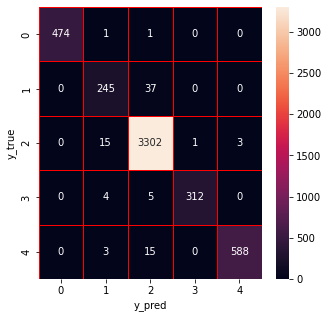

In [42]:
#PSO
#{'n_estimators': 52.5390625, 'max_features': 18.14453125, 'max_depth': 14.66796875, '
#min_samples_split': 9.69921875, 'min_samples_leaf': 2.4453125, 'criterion': 0.87890625}

#BO-TPE
#{'criterion': 1, 'max_depth': 43.0, 'max_features': 19.0, 'min_samples_leaf': 3.0,
#'min_samples_split': 2.0, 'n_estimators': 190.0}

#GA Accuracy of RF: 0.9822213343987215
#criterion=entropy, max_depth=28, max_features=17, min_samples_leaf=3, 
#min_samples_split=2, _n_estimators=26)
rf_hpo = RandomForestClassifier(n_estimators =190, min_samples_leaf = 3, max_depth = 43,
                                min_samples_split = 2, max_features = 19, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [43]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

# Decision Tree

Accuracy of DT: 0.9788254095085897
Precision of DT: 0.9787503625122437
Recall of DT: 0.9788254095085897
F1-score of DT: 0.9787838166883147
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       476
           1       0.87      0.87      0.87       282
           2       0.99      0.99      0.99      3321
           3       0.98      0.98      0.98       321
           4       0.98      0.97      0.98       606

    accuracy                           0.98      5006
   macro avg       0.96      0.96      0.96      5006
weighted avg       0.98      0.98      0.98      5006



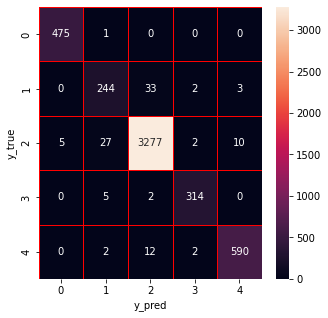

In [44]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### GA

In [82]:


#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    "max_features":range(1,20),
    'max_depth': range(5,50),
    "min_samplesa_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']

             }
# Set the hyperparameters of GA                 
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.tree.DecisionTreeClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)



1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8822813914267341	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=29, DecisionTreeClassifier__max_features=12, DecisionTreeClassifier__min_samples_leaf=10, DecisionTreeClassifier__min_samples_split=6)

Generation 2 - Current Pareto front scores:

-1	0.8822813914267341	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=29, DecisionTreeClassifier__max_features=12, DecisionTreeClassifier__min_samples_leaf=10, DecisionTreeClassifier__min_samples_split=6)

-2	0.8933377012582051	DecisionTreeClassifier(DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=entropy, DecisionTreeClassifier__max_depth=8, DecisionTreeClassifier__max_features=12, DecisionTreeClassifier__min_samples_leaf=3, DecisionTreeClassifier__min_samples_split=5), DecisionTreeClassifier__criterion=entropy, DecisionTreeClassifier__max_depth=4

TPOTClassifier(config_dict={'sklearn.tree.DecisionTreeClassifier': {'criterion': ['gini',
                                                                                  'entropy'],
                                                                    'max_depth': range(5, 50),
                                                                    'max_features': range(1, 20),
                                                                    'min_samples_leaf': range(1, 11),
                                                                    'min_samples_split': range(2, 11)}},
               cv=3, early_stop=5, generations=3, offspring_size=5,
               population_size=10, scoring='accuracy', verbosity=3)

### BO-TPE

In [86]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.26trial/s, best loss: -0.9846184578505793]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 26.0, 'max_features': 19.0, 'min_samples_leaf': 1.0, 'min_samples_split': 5.0}


### PSO

In [56]:

import optunity
import optunity.metrics

data=X
labels=y
# Define the hyperparameter configuration space
search = {
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
         }
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri='gini'
    else:
        cri='entropy'
    model = DecisionTreeClassifier(
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'max_features': 16.640168709353286, 'max_depth': 30.809605931608676, 'min_samples_split': 5.716948931970849, 'min_samples_leaf': 2.2131777131676396, 'criterion': 0.5782561963254416}
Accuracy:0.8985089791846571


## After HPO

Accuracy of DT: 0.9518577706751897
Precision of DT: 0.9509535513551465
Recall of DT: 0.9518577706751897
F1-score of DT: 0.9503112416914382
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       476
           1       0.88      0.65      0.75       282
           2       0.95      0.98      0.97      3321
           3       1.00      0.95      0.97       321
           4       0.91      0.92      0.91       606

    accuracy                           0.95      5006
   macro avg       0.95      0.90      0.92      5006
weighted avg       0.95      0.95      0.95      5006



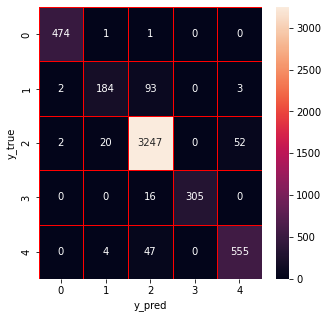

In [45]:
#PSO 没有提升
#{'max_features': 16.640168709353286, 'max_depth': 30.809605931608676, 'min_samples_split': 5.716948931970849, 
 #'min_samples_leaf': 2.2131777131676396, 'criterion': 0.5782561963254416}

# BO-TPE  Accuracy of DT: 0.982820615261686 提升0.1%
# Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 45.0, 
#'max_features': 20.0, 'min_samples_leaf': 2.0, 'min_samples_split': 6.0}
#
#GA  Accuracy of DT: 0.9447236180904522
#(input_matrix, DecisionTreeClassifier__criterion=entropy, DecisionTreeClassifier__max_depth=8, DecisionTreeClassifier__max_features=12, 
 #DecisionTreeClassifier__min_samples_leaf=3, DecisionTreeClassifier__min_samples_split=5)
#criterion=entropy, DecisionTreeClassifier__max_depth=43, DecisionTreeClassifier__max_features=13, 
#DecisionTreeClassifier__min_samples_leaf=5, DecisionTreeClassifier__min_samples_split=6
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 3, max_depth = 8, min_samples_split = 5, 
                                max_features = 12, criterion = 'entropy')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [46]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

# Extra Trees

Accuracy of ET: 0.9768278066320415
Precision of ET: 0.9766726272744407
Recall of ET: 0.9768278066320415
F1-score of ET: 0.9767107264647018
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       476
           1       0.88      0.85      0.87       282
           2       0.98      0.99      0.99      3321
           3       0.99      0.97      0.98       321
           4       0.97      0.96      0.97       606

    accuracy                           0.98      5006
   macro avg       0.96      0.95      0.96      5006
weighted avg       0.98      0.98      0.98      5006



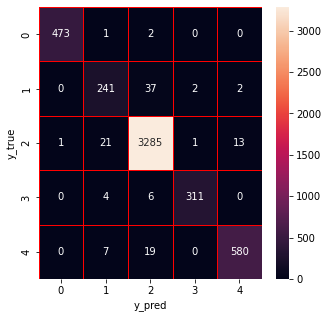

In [47]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### GA

In [51]:


#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(10,200),
    "max_features":range(1,20),
    'max_depth': range(5,50),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
    
             }
# Set the hyperparameters of GA                 
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.ExtraTreesClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)



1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8276864369450325	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__criterion=gini, ExtraTreesClassifier__max_depth=26, ExtraTreesClassifier__max_features=12, ExtraTreesClassifier__min_samples_leaf=1, ExtraTreesClassifier__min_samples_split=7, ExtraTreesClassifier__n_estimators=49)

-2	0.8434279275350277	ExtraTreesClassifier(ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_depth=44, ExtraTreesClassifier__max_features=15, ExtraTreesClassifier__min_samples_leaf=1, ExtraTreesClassifier__min_samples_split=6, ExtraTreesClassifier__n_estimators=48), ExtraTreesClassifier__criterion=gini, ExtraTreesClassifier__max_depth=40, ExtraTreesClassifier__max_features=11, ExtraTreesClassifier__min_samples_leaf=3, ExtraTreesClassifier__min_samples_split=6, ExtraTreesClassifier__n_estimators=49)

Generation 2 - Current Pareto front scores:

-1	0.8276864369450325	ExtraTreesClassifier(input_matrix, 

TPOTClassifier(config_dict={'sklearn.ensemble.ExtraTreesClassifier': {'criterion': ['gini',
                                                                                    'entropy'],
                                                                      'max_depth': range(5, 50),
                                                                      'max_features': range(1, 20),
                                                                      'min_samples_leaf': range(1, 11),
                                                                      'min_samples_split': range(2, 11),
                                                                      'n_estimators': range(10, 200)}},
               cv=3, early_stop=5, generations=3, offspring_size=5,
               population_size=10, scoring='accuracy', verbosity=3)

### BO-TPE

In [91]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:30<00:00,  1.50s/trial, best loss: -0.9790251697962445]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 23.0, 'max_features': 14.0, 'min_samples_leaf': 3.0, 'min_samples_split': 5.0, 'n_estimators': 175.0}


### PSO

In [65]:
import optunity
import optunity.metrics

data=X
labels=y
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10,200],
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
         }
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test, n_estimators=None,max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri='gini'
    else:
        cri='entropy'
    model = ExtraTreesClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))
Accuracy of ET: 0.9836196564123052

{'n_estimators': 159.5322265625, 'max_features': 17.052862004903464, 'max_depth': 48.13951914998281, 'min_samples_split': 3.3291688337522647, 'min_samples_leaf': 6.5283203125, 'criterion': 0.56630859375}
Accuracy:0.8445330773286049


Accuracy of ET: 0.9822213343987215
Precision of ET: 0.9820827569480821
Recall of ET: 0.9822213343987215
F1-score of ET: 0.9820476204592857
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       476
           1       0.92      0.87      0.89       282
           2       0.98      0.99      0.99      3321
           3       0.99      0.97      0.98       321
           4       0.99      0.97      0.98       606

    accuracy                           0.98      5006
   macro avg       0.98      0.96      0.97      5006
weighted avg       0.98      0.98      0.98      5006



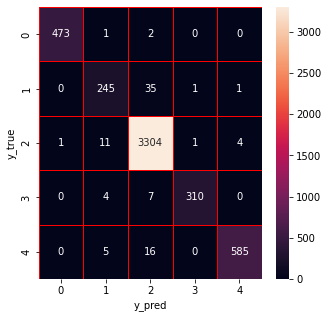

In [53]:
#PSO  Accuracy of ET: 0.9730323611666001 下降
#{'n_estimators': 159.5322265625, 'max_features': 17.052862004903464, 'max_depth': 48.13951914998281, 'min_samples_split': 3.3291688337522647, 
# 'min_samples_leaf': 6.5283203125, 'criterion': 0.56630859375}

#BO-TPE Accuracy of ET: 0.9836196564123052 提升
#{'criterion': 0, 'max_depth': 22.0, 'max_features': 15.0, 'min_samples_leaf': 1.0, 
#'min_samples_split': 7.0, 'n_estimators': 107.0}

#GA Accuracy of ET: 0.9822213343987215
#ExtraTreesClassifier__criterion=entropy,max_depth=24, ExtraTreesClassifier__max_features=18, 
#min_samples_leaf=9, ExtraTreesClassifier__min_samples_split=5,ExtraTreesClassifier__n_estimators=154)
et_hpo = ExtraTreesClassifier(n_estimators = 49, min_samples_leaf = 1, max_depth = 24, 
                              min_samples_split = 7, max_features = 16, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [93]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

In [94]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,2,2,2,2
1,0,0,0,0
2,2,2,2,2
3,4,4,4,4
4,2,2,2,2


In [95]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [96]:
dt_train.shape

(20024, 1)

In [97]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9872153415900919
Precision of Stacking: 0.9871976853982446
Recall of Stacking: 0.9872153415900919
F1-score of Stacking: 0.9871734278640755
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       476
           1       0.94      0.92      0.93       277
           2       0.99      1.00      0.99      3328
           3       0.99      0.98      0.99       320
           4       0.99      0.97      0.98       605

    accuracy                           0.99      5006
   macro avg       0.98      0.97      0.98      5006
weighted avg       0.99      0.99      0.99      5006



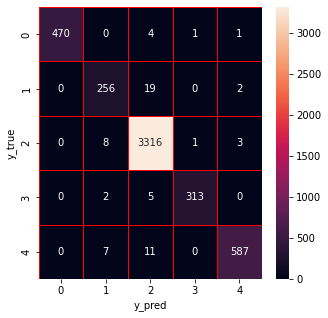

In [98]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [99]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29trial/s, best loss: -0.9874151018777467]
XGBoost: Hyperopt estimated optimum {'learning_rate': 1.3543548153564335, 'max_depth': 92.0, 'n_estimators': 45.0}


Accuracy of XGBoost: 0.9872153415900919
Precision of XGBoost: 0.9872103947841724
Recall of XGBoost: 0.9872153415900919
F1-score of XGBoost: 0.987178884512277
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       476
           1       0.93      0.92      0.93       277
           2       0.99      1.00      0.99      3328
           3       0.99      0.98      0.99       320
           4       0.99      0.97      0.98       605

    accuracy                           0.99      5006
   macro avg       0.98      0.97      0.98      5006
weighted avg       0.99      0.99      0.99      5006



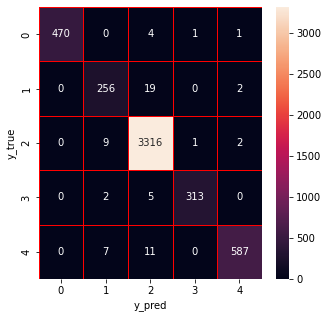

In [100]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()